In [1]:
# =============================================================================
# 1. SETUP AND DATA PREPARATION
# =============================================================================

import sys, os, warnings
sys.path.append('../')
warnings.filterwarnings('ignore')
os.chdir('game-behavior-analytics/data_analysis_notebook/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load and prepare data
df = pd.read_csv("../data/final_dataset.csv")

def categorize_cheating(rate):
    return 0 if rate == 0 else 2 if rate == 1 else 1

# Create analysis variables
df['cheating_behavior'] = df['cheating_rate_main_round'].apply(categorize_cheating)
df['experience'] = (df['task_satisfaction'] + df['task_engagement']) / 2
df['performance'] = df['performance_score_including_cheated_words']
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept'])

# Prepare categorical variables
concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])

concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

# Create nested message structure: concept -> messages
message_df = df[['concept', 'motivational_message_id']].drop_duplicates()
concept_message_map = {}
for concept in concept_ids.cat.categories:
    messages = message_df[message_df['concept'] == concept]['motivational_message_id'].unique()
    concept_message_map[concept] = {msg: i for i, msg in enumerate(messages)}

# Create nested message indices
df['concept_idx'] = concept_codes
df['message_within_concept'] = df.apply(
    lambda row: concept_message_map[row['concept']][row['motivational_message_id']], axis=1
)


In [4]:
# =============================================================================
# RQ1: CHEATING BEHAVIOR MODEL
# =============================================================================

with pm.Model() as cheating_model:
    # Uninformative intercepts
    beta_partial_intercept = pm.Normal('beta_partial_intercept', mu=0, sigma=1)
    beta_full_intercept = pm.Normal('beta_full_intercept', mu=0, sigma=1)
    
    # Hierarchical concept effects
    mu_concept_partial = pm.Normal('mu_concept_partial', mu=0, sigma=1)
    sigma_concept_partial = pm.HalfNormal('sigma_concept_partial', sigma=1)
    
    concept_effects_partial = pm.Normal('concept_effects_partial', 
                                       mu=mu_concept_partial, sigma=sigma_concept_partial, 
                                       shape=len(concepts))
    
    mu_concept_full = pm.Normal('mu_concept_full', mu=0, sigma=1)
    sigma_concept_full = pm.HalfNormal('sigma_concept_full', sigma=1)
    
    concept_effects_full = pm.Normal('concept_effects_full', 
                                    mu=mu_concept_full, sigma=sigma_concept_full, 
                                    shape=len(concepts))
    
    # Linear predictors
    concept_effect_partial = pm.math.switch(df['concept_idx'].values > 0, 
                                           concept_effects_partial[df['concept_idx'].values - 1], 0)
    concept_effect_full = pm.math.switch(df['concept_idx'].values > 0, 
                                       concept_effects_full[df['concept_idx'].values - 1], 0)
    
    eta_partial = beta_partial_intercept + concept_effect_partial
    eta_full = beta_full_intercept + concept_effect_full
    
    # Multinomial logistic probabilities
    logits = pm.math.stack([pm.math.zeros(eta_partial.shape), eta_partial, eta_full], axis=1)
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('cheating_observed', p=probs, observed=df['cheating_behavior'].values)

with cheating_model:
    trace_cheating = pm.sample(
        draws=1500,
        tune=2000,
        chains=4,
        cores=4,
        target_accept=0.95,
        max_treedepth=12,
        init='jitter+adapt_diag',
        random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_concept_partial, sigma_concept_partial, concept_effects_partial, mu_concept_full, sigma_concept_full, concept_effects_full]


Output()

Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 187 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
with cheating_model:
    ppc_cheating_prior = pm.sample_prior_predictive(model=cheating_model)
    ppc_cheating_posterior = pm.sample_posterior_predictive(trace_cheating, random_seed=42)

Sampling: [beta_full_intercept, beta_partial_intercept, cheating_observed, concept_effects_full, concept_effects_partial, mu_concept_full, mu_concept_partial, sigma_concept_full, sigma_concept_partial]
Sampling: [cheating_observed]


Output()

<Axes: xlabel='cheating_observed'>

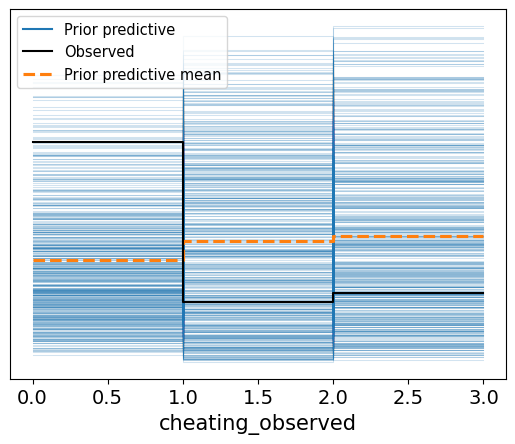

In [17]:
az.plot_ppc(ppc_cheating_prior, group='prior', observed=True)

<Axes: xlabel='cheating_observed'>

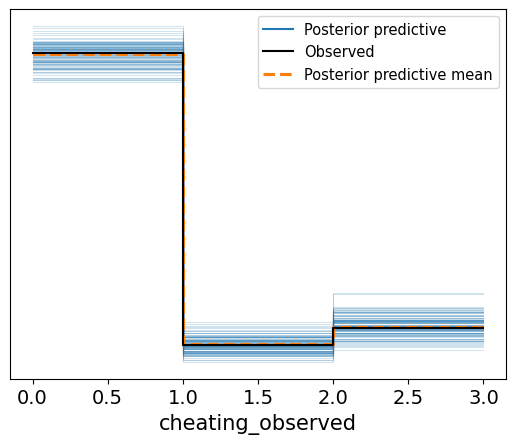

In [18]:
az.plot_ppc(ppc_cheating_posterior, num_pp_samples=100)

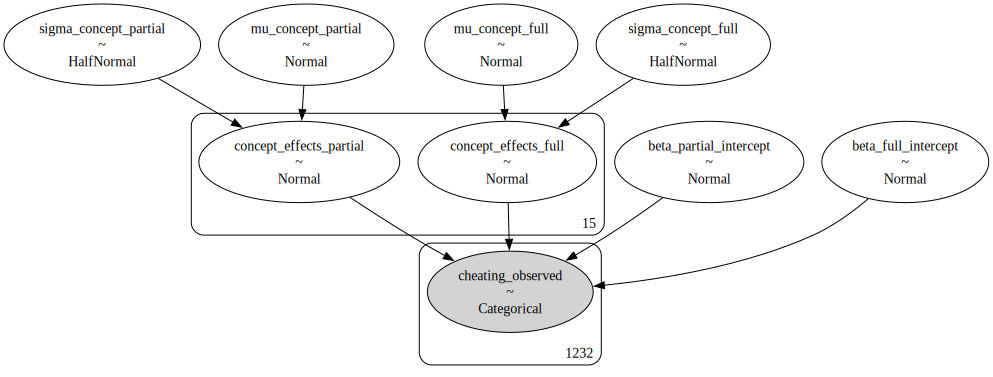

In [19]:
pm.model_to_graphviz(cheating_model)

In [3]:
# =============================================================================
# RQ2: PERFORMANCE MODEL
# =============================================================================

with pm.Model() as performance_model:

    beta_perf_intercept = pm.Normal('beta_perf_intercept', mu=0, sigma=50, shape=3)

    mu_concept_perf = pm.Normal('mu_concept_perf', mu=0, sigma=5)
    sigma_concept_perf = pm.HalfNormal('sigma_concept_perf', sigma=5)
    
    concept_perf_main = pm.Normal('concept_perf_main', mu=mu_concept_perf, sigma=sigma_concept_perf, shape=len(concepts))
    
    mu_concept_perf_interactions = pm.Normal('mu_concept_perf_interactions', mu=0, sigma=5, shape=3)
    sigma_concept_perf_interactions = pm.HalfNormal('sigma_concept_perf_interactions', sigma=5, shape=3)
    
    concept_perf_interactions = pm.Normal('concept_perf_interactions', 
                                         mu=mu_concept_perf_interactions, sigma=sigma_concept_perf_interactions, 
                                         shape=(len(concepts), 3))
    
    # Linear predictor
    mu_perf = beta_perf_intercept[df['cheating_behavior'].values]
    
    # Add concept effects for intervention groups
    concept_effect = pm.math.switch(
        df['concept_idx'].values > 0,
        concept_perf_main[df['concept_idx'].values - 1] + 
        concept_perf_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
        0
    )
    
    mu_perf = mu_perf + concept_effect
    
    # Residual standard deviation
    sigma_perf = pm.HalfNormal('sigma_perf', sigma=10)
    
    # Likelihood
    pm.TruncatedNormal('performance_observed', mu=mu_perf, sigma=sigma_perf,
                      lower=0, upper=df['performance'].max() + 20, 
                      observed=df['performance'].values)

print("Fitting RQ2: Performance Model...")
with performance_model:
    trace_performance = pm.sample(1500, tune=2000, chains=4, cores=4, target_accept=0.9, random_seed=42)

Fitting RQ2: Performance Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_perf_intercept, mu_concept_perf, sigma_concept_perf, concept_perf_main, mu_concept_perf_interactions, sigma_concept_perf_interactions, concept_perf_interactions, sigma_perf]


Output()

Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 553 seconds.
There were 349 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
with performance_model:
    ppc_performance_prior = pm.sample_prior_predictive(model=performance_model)
    ppc_performance_posterior = pm.sample_posterior_predictive(trace_performance, random_seed=42)

Sampling: [beta_perf_intercept, concept_perf_interactions, concept_perf_main, mu_concept_perf, mu_concept_perf_interactions, performance_observed, sigma_concept_perf, sigma_concept_perf_interactions, sigma_perf]
Sampling: [performance_observed]


Output()

<Axes: xlabel='performance_observed'>

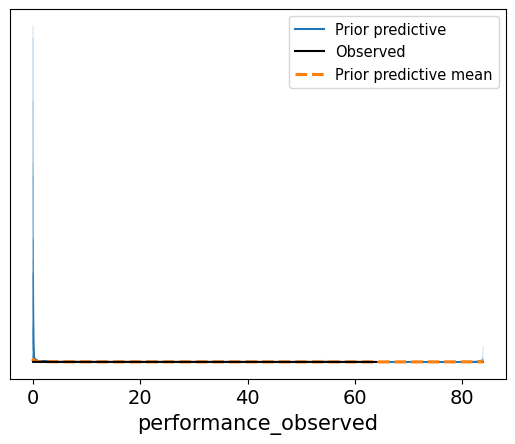

In [7]:
az.plot_ppc(ppc_performance_prior, group='prior', observed=True)

<Axes: xlabel='performance_observed'>

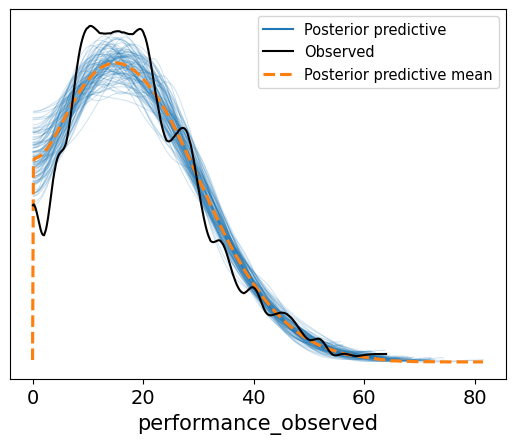

In [8]:
az.plot_ppc(ppc_performance_posterior, num_pp_samples=100)

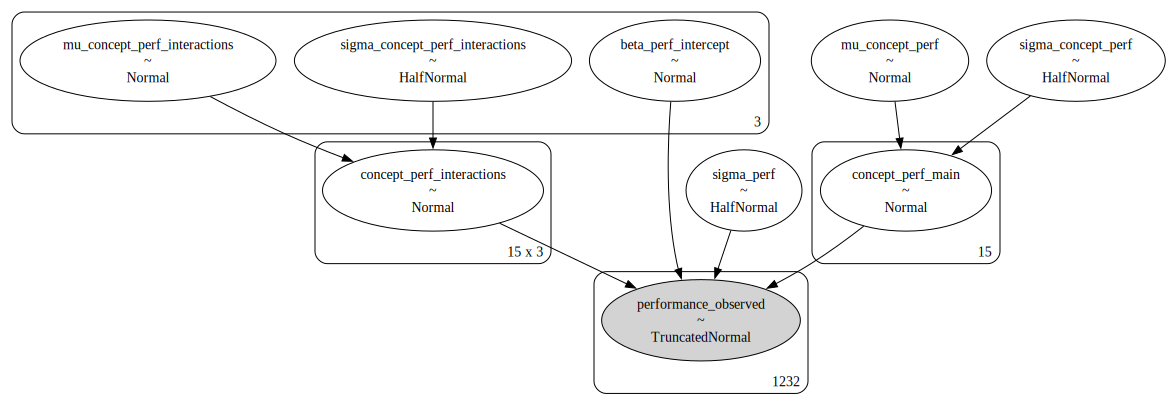

In [9]:
pm.model_to_graphviz(performance_model)

In [2]:
# =============================================================================
# RQ3: EXPERIENCE MODEL
# =============================================================================

with pm.Model() as experience_model:

    beta_exp_intercept = pm.Normal('beta_exp_intercept', mu=0, sigma=10, shape=3)
    
    mu_concept_exp = pm.Normal('mu_concept_exp', mu=0, sigma=2)
    sigma_concept_exp = pm.HalfNormal('sigma_concept_exp', sigma=2)
    
    concept_exp_main = pm.Normal('concept_exp_main', mu=mu_concept_exp, sigma=sigma_concept_exp, shape=len(concepts))
    
    mu_concept_exp_interactions = pm.Normal('mu_concept_exp_interactions', mu=0, sigma=2, shape=3)
    sigma_concept_exp_interactions = pm.HalfNormal('sigma_concept_exp_interactions', sigma=2, shape=3)
    
    concept_exp_interactions = pm.Normal('concept_exp_interactions', 
                                        mu=mu_concept_exp_interactions, sigma=sigma_concept_exp_interactions, 
                                        shape=(len(concepts), 3))
    
    # Linear predictor
    mu_exp = beta_exp_intercept[df['cheating_behavior'].values]
    
    # Add concept effects for intervention groups
    concept_effect = pm.math.switch(
        df['concept_idx'].values > 0,
        concept_exp_main[df['concept_idx'].values - 1] + 
        concept_exp_interactions[df['concept_idx'].values - 1, df['cheating_behavior'].values],
        0
    )
    
    mu_exp = mu_exp + concept_effect
    
    # Residual standard deviation
    sigma_exp = pm.HalfNormal('sigma_exp', sigma=2)
    
    # Likelihood
    pm.TruncatedNormal('experience_observed', mu=mu_exp, sigma=sigma_exp,
                      lower=1, upper=7, 
                      observed=df['experience'].values)

print("Fitting RQ3: Experience Model...")
with experience_model:
    trace_experience = pm.sample(1500, tune=2000, chains=4, cores=4, target_accept=0.9, random_seed=42)

Fitting RQ3: Experience Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_exp_intercept, mu_concept_exp, sigma_concept_exp, concept_exp_main, mu_concept_exp_interactions, sigma_concept_exp_interactions, concept_exp_interactions, sigma_exp]


Output()

Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 808 seconds.
There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
with experience_model:
    ppc_experience_prior = pm.sample_prior_predictive(model=experience_model)
    ppc_experience_posterior = pm.sample_posterior_predictive(trace_experience, random_seed=42)

Sampling: [beta_exp_intercept, concept_exp_interactions, concept_exp_main, experience_observed, mu_concept_exp, mu_concept_exp_interactions, sigma_concept_exp, sigma_concept_exp_interactions, sigma_exp]
Sampling: [experience_observed]


Output()

<Axes: xlabel='experience_observed'>

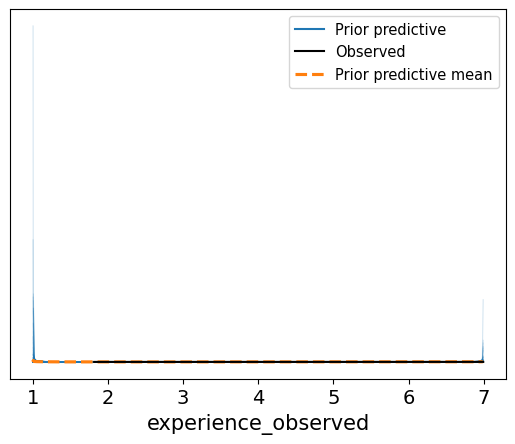

In [11]:
az.plot_ppc(ppc_experience_prior, group='prior', observed=True)

<Axes: xlabel='experience_observed'>

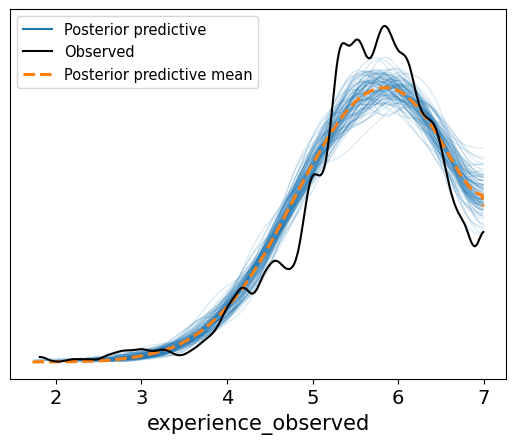

In [12]:
az.plot_ppc(ppc_experience_posterior, num_pp_samples=100)

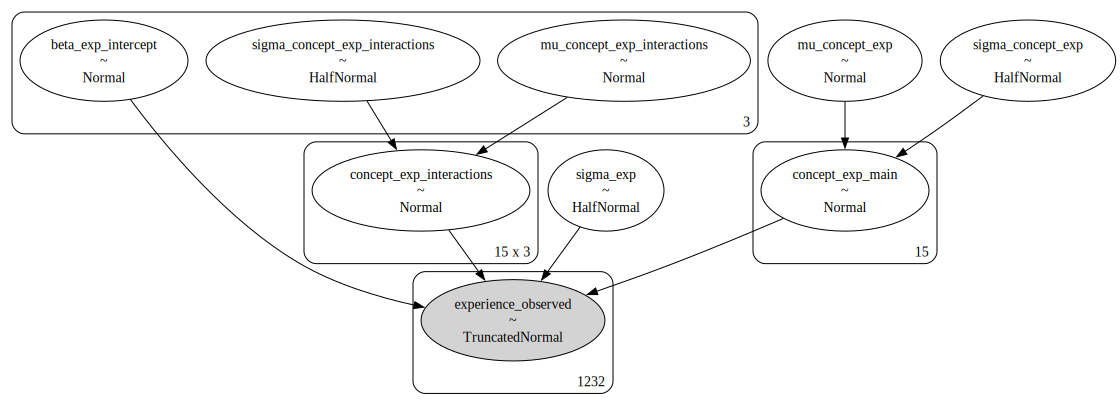

In [13]:
pm.model_to_graphviz(experience_model)

In [15]:
# =============================================================================
# RQ1 RESULTS: CHEATING BEHAVIOR
# =============================================================================

beta_partial_samples = trace_cheating.posterior['beta_partial_intercept'].values.flatten()
beta_full_samples = trace_cheating.posterior['beta_full_intercept'].values.flatten()
partial_effects = trace_cheating.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

# Control group probabilities
control_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples,
    beta_full_samples
])
control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

results_cheating = []
for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        concept_logits = np.column_stack([
            np.zeros(len(beta_partial_samples)),
            beta_partial_samples + partial_effects[:, i],
            beta_full_samples + full_effects[:, i]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
        
        non_diff = (concept_probs[:, 0] - control_probs[:, 0]) * 100
        partial_diff = (concept_probs[:, 1] - control_probs[:, 1]) * 100
        full_diff = (concept_probs[:, 2] - control_probs[:, 2]) * 100
        
        results_cheating.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': non_diff.mean(),
            'Non_hdi': az.hdi(non_diff, hdi_prob=0.95),
            'Partial_mean': partial_diff.mean(),
            'Partial_hdi': az.hdi(partial_diff, hdi_prob=0.95),
            'Full_mean': full_diff.mean(),
            'Full_hdi': az.hdi(full_diff, hdi_prob=0.95)
        })

df_results_cheating = pd.DataFrame(results_cheating)

# Overall intervention effects
overall_partial_effects = partial_effects.mean(axis=1)  
overall_full_effects = full_effects.mean(axis=1)

overall_logits = np.column_stack([
    np.zeros(len(beta_partial_samples)),
    beta_partial_samples + overall_partial_effects,
    beta_full_samples + overall_full_effects
])
overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

overall_results_cheating = {}
for i, category in enumerate(['Non', 'Partial', 'Full']):
    diff = (overall_probs[:, i] - control_probs[:, i]) * 100
    overall_results_cheating[category] = {
        'mean': diff.mean(),
        'hdi': az.hdi(diff, hdi_prob=0.95)
    }

control_rates = {
    'Non': control_probs[:, 0].mean() * 100,
    'Partial': control_probs[:, 1].mean() * 100,
    'Full': control_probs[:, 2].mean() * 100
}

print("\nRQ1: CHEATING BEHAVIOR CHANGES (percentage points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results_cheating.iterrows():
    non_str = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
    partial_str = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
    full_str = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")

# =============================================================================
# RQ2 RESULTS: PERFORMANCE
# =============================================================================

# Fixed variable names to match the model definition
control_means_samples = trace_performance.posterior['beta_perf_intercept'].values.reshape(-1, 3)
concept_main_samples = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
concept_interactions_samples = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)

results_performance = []
for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        
        differences = {}
        for cheat_cat in [0, 1, 2]:
            control_baseline = control_means_samples[:, cheat_cat]
            intervention_effect = (control_baseline + 
                                 concept_main_samples[:, i] + 
                                 concept_interactions_samples[:, i, cheat_cat])
            diff = intervention_effect - control_baseline
            differences[cheat_cat] = diff
        
        results_performance.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': differences[0].mean(),
            'Non_hdi': az.hdi(differences[0], hdi_prob=0.95),
            'Partial_mean': differences[1].mean(),
            'Partial_hdi': az.hdi(differences[1], hdi_prob=0.95),
            'Full_mean': differences[2].mean(),
            'Full_hdi': az.hdi(differences[2], hdi_prob=0.95)
        })

df_results_perf = pd.DataFrame(results_performance)

overall_effects_perf = {}
for cheat_cat in [0, 1, 2]:
    all_concept_effects = []
    for i in range(len(concepts)):
        control_baseline = control_means_samples[:, cheat_cat]
        intervention_effect = (control_baseline + 
                             concept_main_samples[:, i] + 
                             concept_interactions_samples[:, i, cheat_cat])
        diff = intervention_effect - control_baseline
        all_concept_effects.append(diff)
    
    overall_diff = np.mean(all_concept_effects, axis=0)
    overall_effects_perf[cheat_cat] = {
        'mean': overall_diff.mean(),
        'hdi': az.hdi(overall_diff, hdi_prob=0.95)
    }

control_baselines_perf = {
    'Non': control_means_samples[:, 0].mean(),
    'Partial': control_means_samples[:, 1].mean(),
    'Full': control_means_samples[:, 2].mean()
}

print("\nRQ2: PERFORMANCE CHANGES (points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results_perf.iterrows():
    non_str = f"{row['Non_mean']:+.2f} [{row['Non_hdi'][0]:+.2f}, {row['Non_hdi'][1]:+.2f}]"
    partial_str = f"{row['Partial_mean']:+.2f} [{row['Partial_hdi'][0]:+.2f}, {row['Partial_hdi'][1]:+.2f}]"
    full_str = f"{row['Full_mean']:+.2f} [{row['Full_hdi'][0]:+.2f}, {row['Full_hdi'][1]:+.2f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")

# =============================================================================
# RQ3 RESULTS: EXPERIENCE
# =============================================================================

# Fixed variable names to match the model definition
control_means_samples = trace_experience.posterior['beta_exp_intercept'].values.reshape(-1, 3)
concept_main_samples = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
concept_interactions_samples = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)

results_experience = []
for concept in theory_order:
    if concept in concepts:
        i = concepts.index(concept)
        
        differences = {}
        for cheat_cat in [0, 1, 2]:
            control_baseline = control_means_samples[:, cheat_cat]
            intervention_effect = (control_baseline + 
                                 concept_main_samples[:, i] + 
                                 concept_interactions_samples[:, i, cheat_cat])
            diff = intervention_effect - control_baseline
            differences[cheat_cat] = diff
        
        results_experience.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': differences[0].mean(),
            'Non_hdi': az.hdi(differences[0], hdi_prob=0.95),
            'Partial_mean': differences[1].mean(),
            'Partial_hdi': az.hdi(differences[1], hdi_prob=0.95),
            'Full_mean': differences[2].mean(),
            'Full_hdi': az.hdi(differences[2], hdi_prob=0.95)
        })

df_results_exp = pd.DataFrame(results_experience)

overall_effects_exp = {}
for cheat_cat in [0, 1, 2]:
    all_concept_effects = []
    for i in range(len(concepts)):
        control_baseline = control_means_samples[:, cheat_cat]
        intervention_effect = (control_baseline + 
                             concept_main_samples[:, i] + 
                             concept_interactions_samples[:, i, cheat_cat])
        diff = intervention_effect - control_baseline
        all_concept_effects.append(diff)
    
    overall_diff = np.mean(all_concept_effects, axis=0)
    overall_effects_exp[cheat_cat] = {
        'mean': overall_diff.mean(),
        'hdi': az.hdi(overall_diff, hdi_prob=0.95)
    }

control_baselines_exp = {
    'Non': control_means_samples[:, 0].mean(),
    'Partial': control_means_samples[:, 1].mean(),
    'Full': control_means_samples[:, 2].mean()
}

print("\nRQ3: EXPERIENCE CHANGES (points) with 95% HDI:")
print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
print("-" * 130)
for _, row in df_results_exp.iterrows():
    non_str = f"{row['Non_mean']:+.2f} [{row['Non_hdi'][0]:+.2f}, {row['Non_hdi'][1]:+.2f}]"
    partial_str = f"{row['Partial_mean']:+.2f} [{row['Partial_hdi'][0]:+.2f}, {row['Partial_hdi'][1]:+.2f}]"
    full_str = f"{row['Full_mean']:+.2f} [{row['Full_hdi'][0]:+.2f}, {row['Full_hdi'][1]:+.2f}]"
    print(f"{row['Concept']:<35} {row['Theory']:<30} {non_str:<25} {partial_str:<25} {full_str:<25}")


RQ1: CHEATING BEHAVIOR CHANGES (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +11.9 [+0.3, +22.4]       +2.9 [-5.0, +10.9]        -14.7 [-24.9, -2.4]      
Competence                          Self-Determination Theory      +11.9 [+0.9, +23.2]       +1.5 [-6.6, +9.4]         -13.5 [-23.4, -1.8]      
Relatedness                         Self-Determination Theory      +11.6 [+0.3, +22.3]       +1.4 [-6.7, +9.2]         -13.0 [-23.5, -1.5]      
Self Concept                        Cognitive Dissonance Theory    +11.6 [+0.9, +23.0]       +2.4 [-6.1, +9.7]         -14.0 [-25.0, -3.1]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +12.0 [+0.1

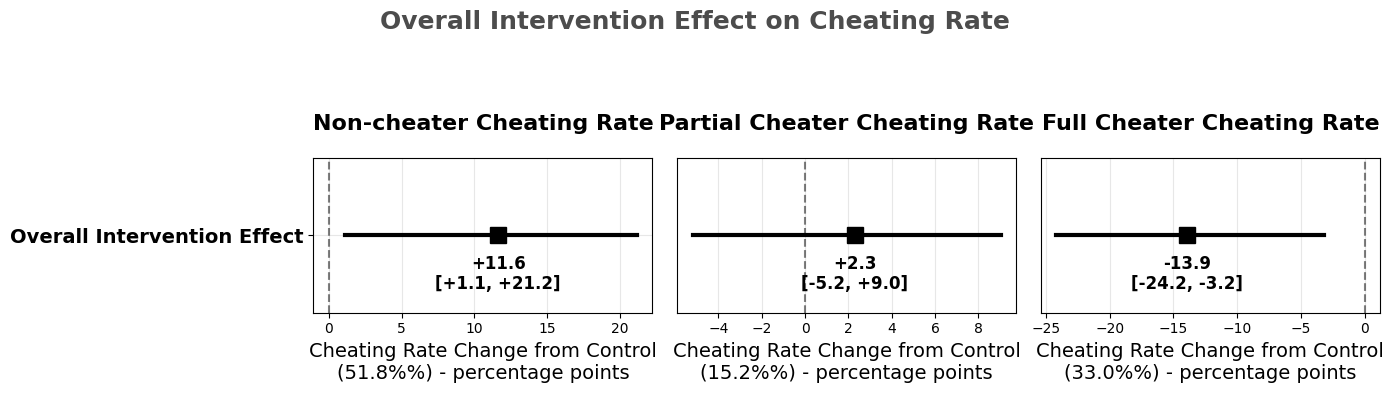

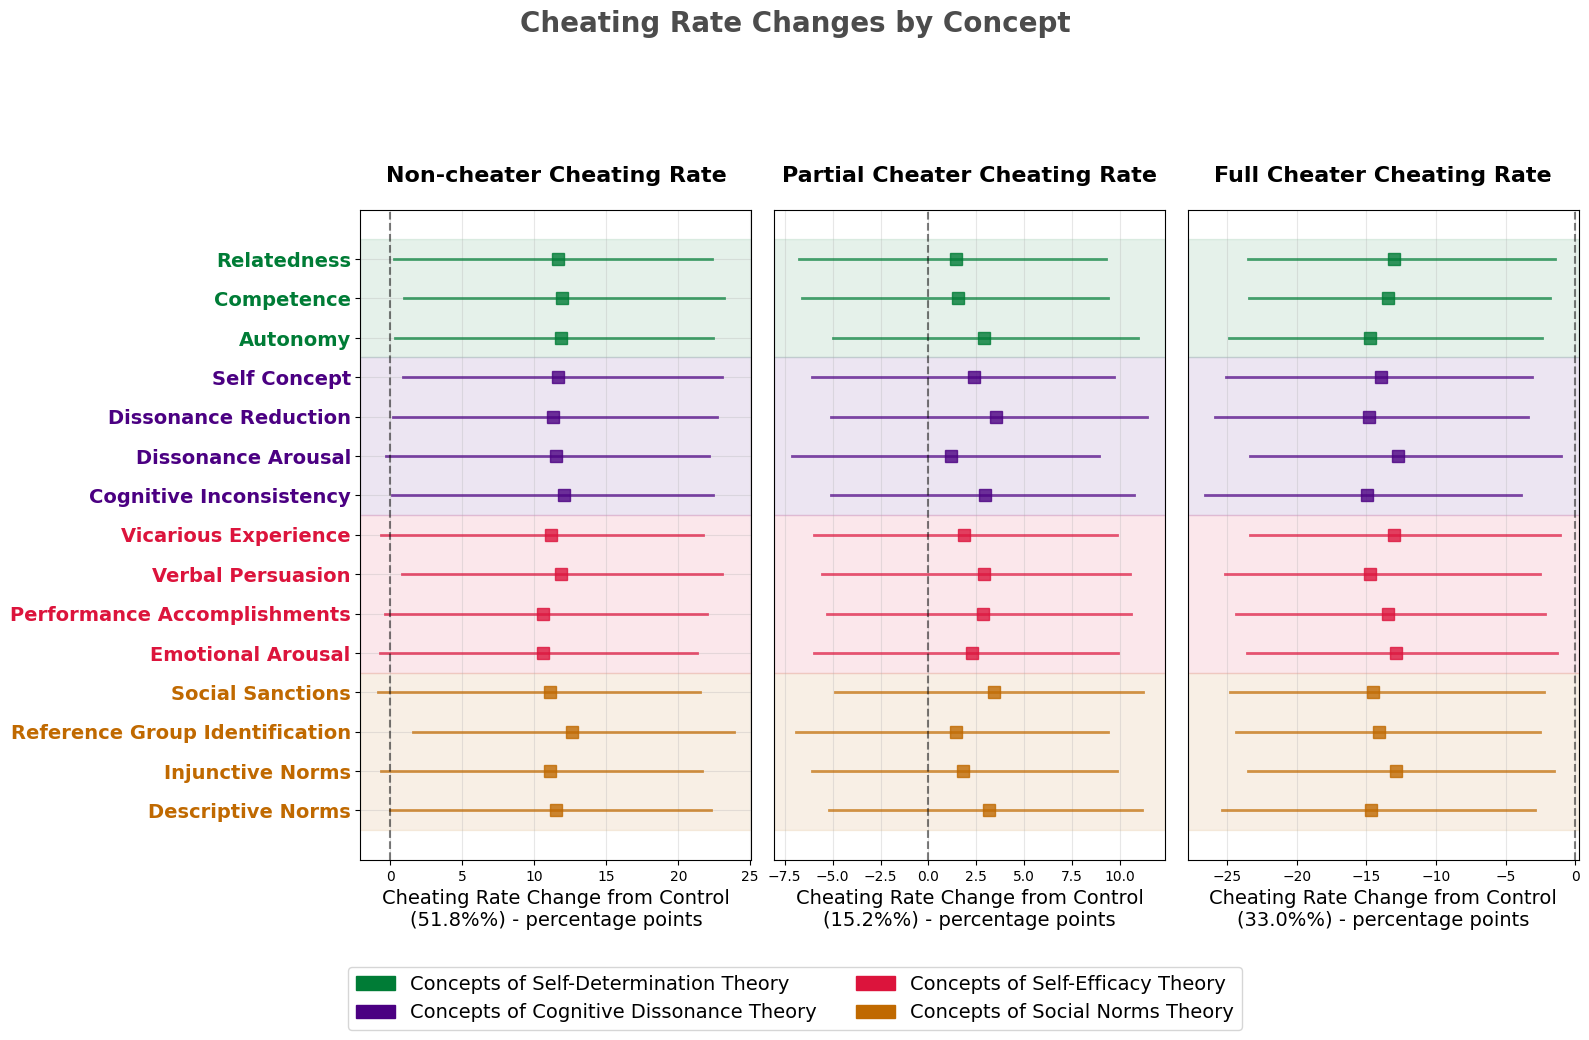

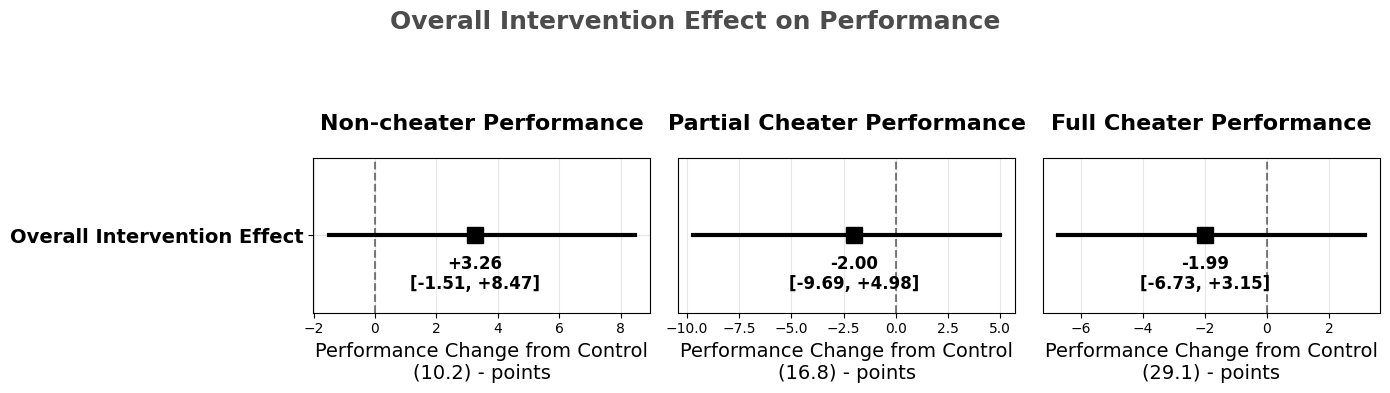

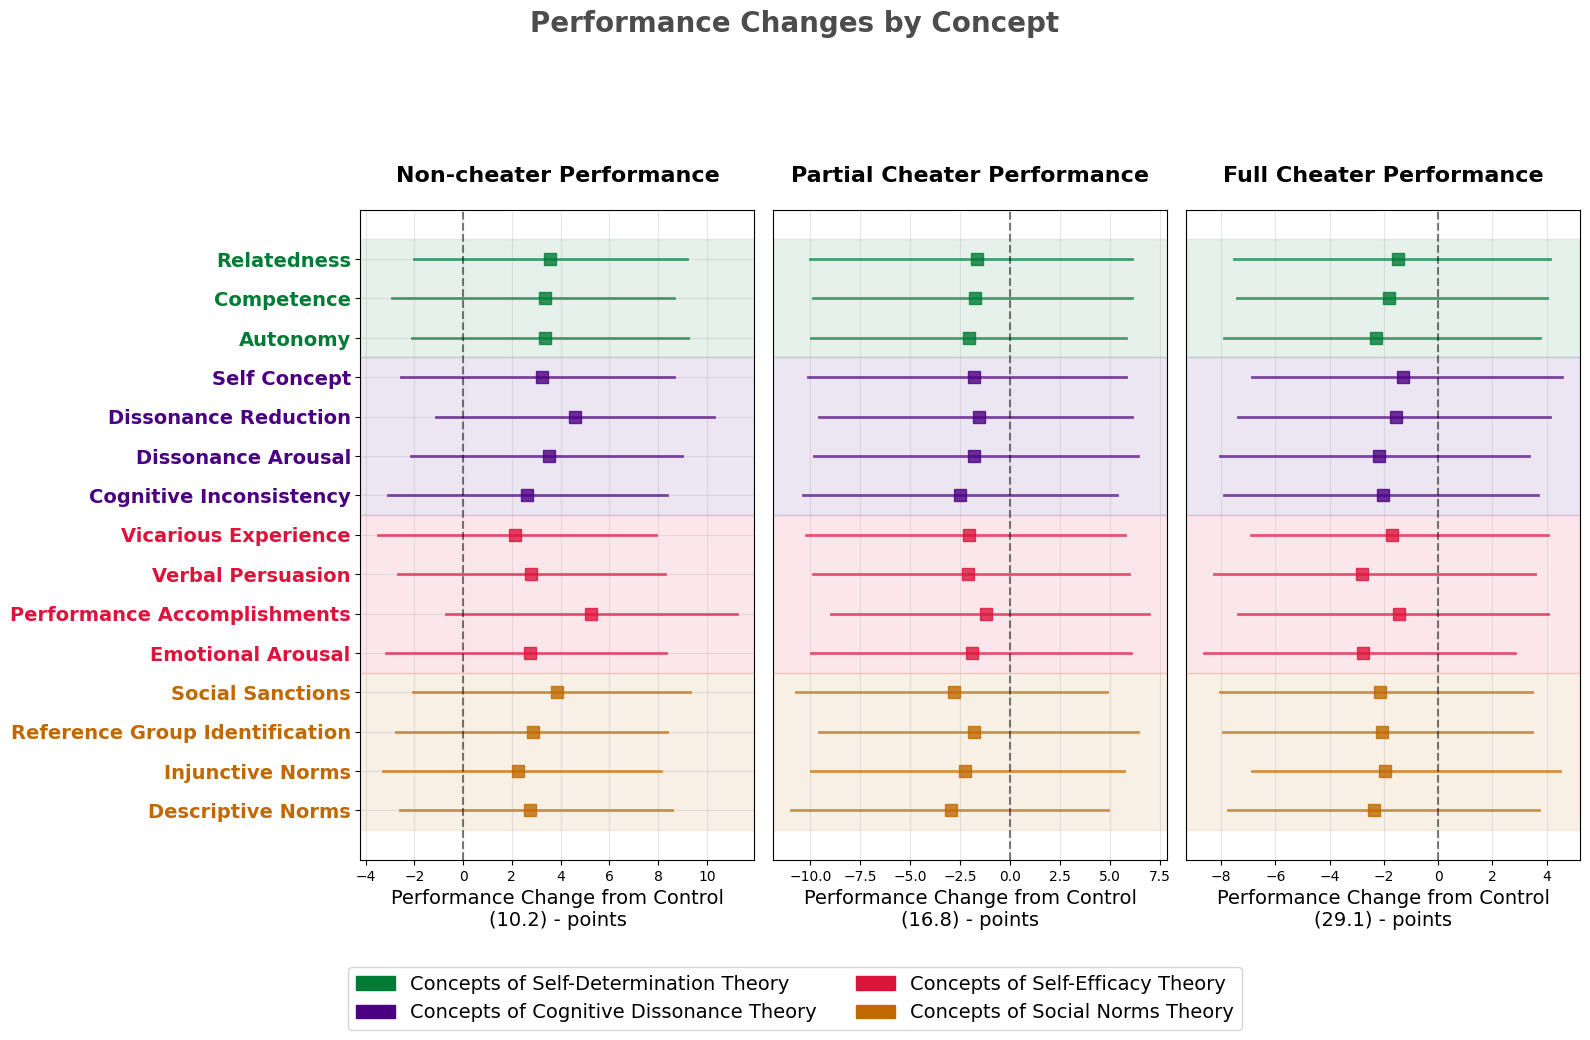

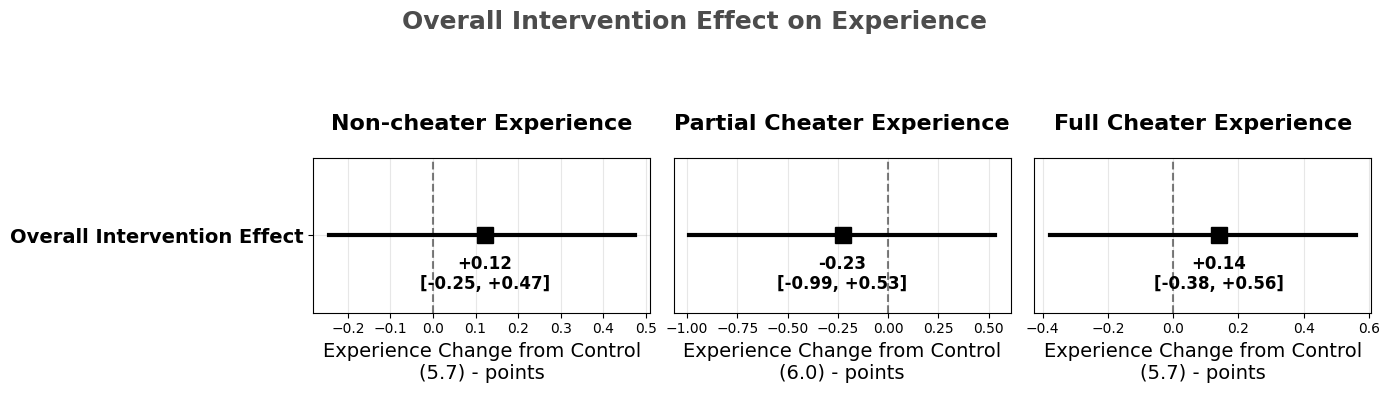

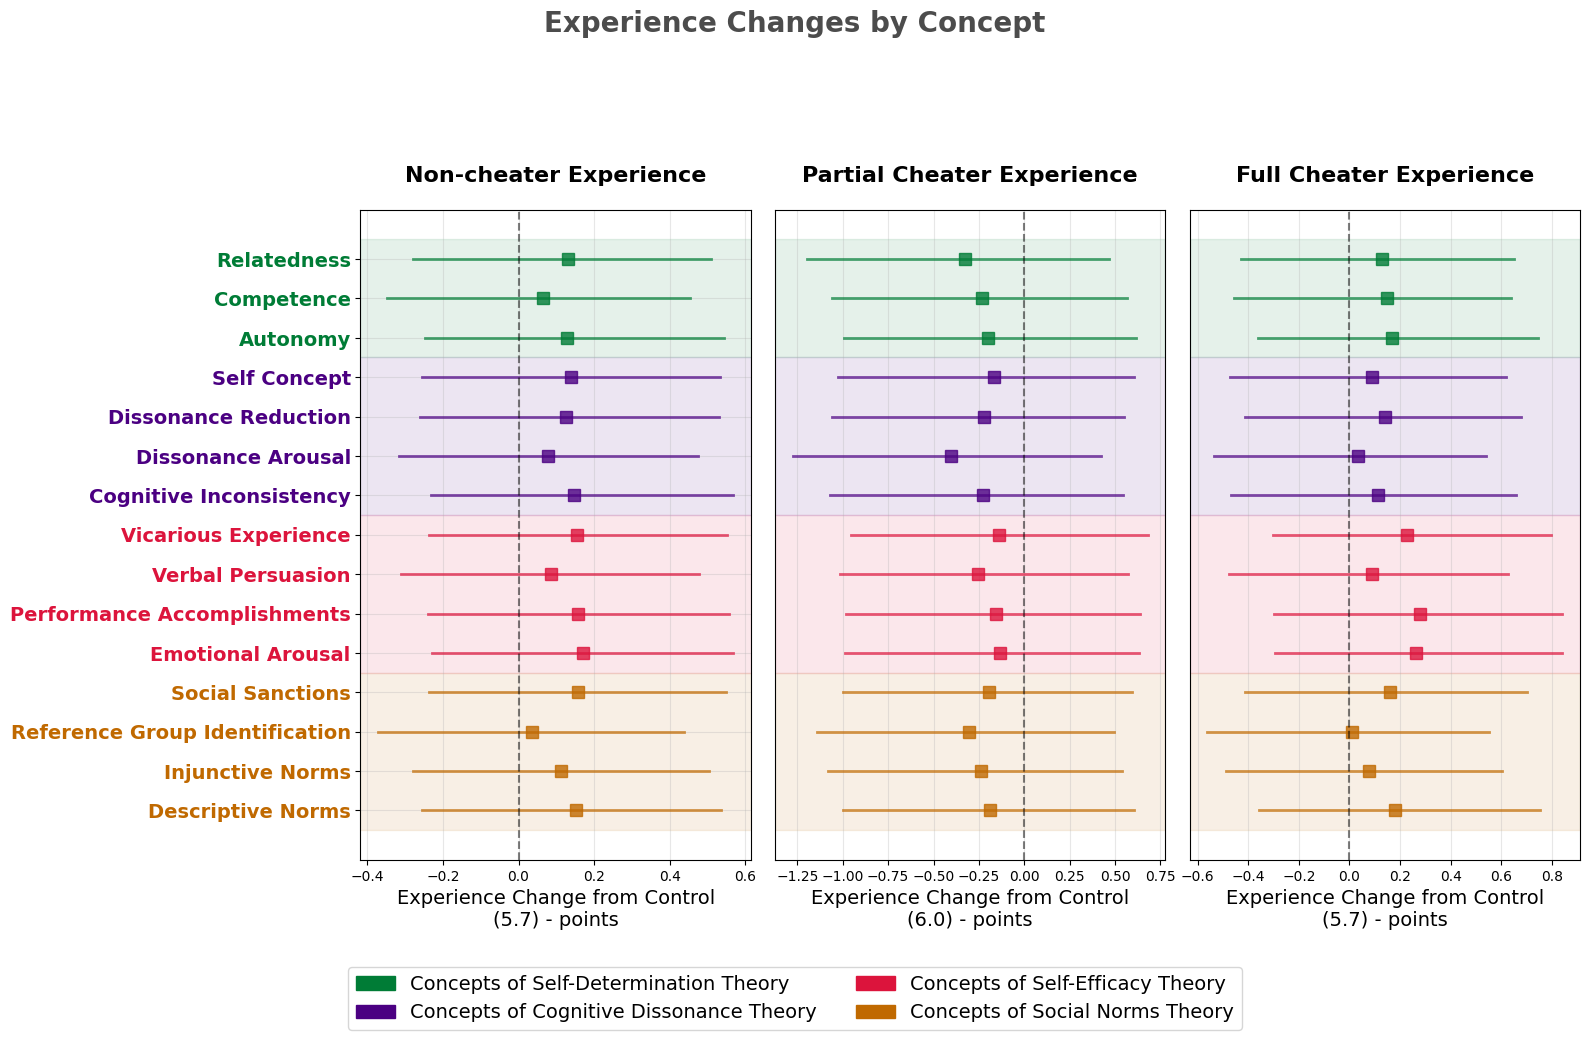


SEPARATE MODELS ANALYSIS COMPLETE


In [16]:
# =============================================================================
# FOREST PLOTS
# =============================================================================

import matplotlib.patches as patches

categories = ['Non', 'Partial', 'Full']
theory_order_viz = ['Self-Determination Theory', 'Cognitive Dissonance Theory', 'Self-Efficacy Theory', 'Social Norms Theory'][::-1]
theory_colors = {'Self-Determination Theory': "#007C36", 'Cognitive Dissonance Theory': '#4B0082',
                 'Self-Efficacy Theory': '#DC143C', 'Social Norms Theory': "#C06900"}

def create_forest_plots(df_results, overall_results, control_baselines, outcome_name, units):
    titles = [f'Non-cheater {outcome_name}', f'Partial Cheater {outcome_name}', f'Full Cheater {outcome_name}']
    
    # Overall effects
    fig1, axes1 = plt.subplots(1, 3, figsize=(14, 4))
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes1[idx]
        
        mean = overall_results[cat]['mean'] if cat in overall_results else overall_results[idx]['mean']
        hdi = overall_results[cat]['hdi'] if cat in overall_results else overall_results[idx]['hdi']
        
        ax.plot([hdi[0], hdi[1]], [0, 0], color='black', linewidth=3)
        ax.plot(mean, 0, 's', color='black', markersize=12)
        
        precision = 1 if units == 'pp' else 2
        ax.text(mean, -0.15, f'{mean:+.{precision}f}\n[{hdi[0]:+.{precision}f}, {hdi[1]:+.{precision}f}]', 
                ha='center', va='center', fontweight='bold', fontsize=12)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)
        
        if idx == 0:
            ax.set_yticks([0])
            ax.set_yticklabels(['Overall Intervention Effect'], fontsize=14, fontweight='bold')
        else:
            ax.set_yticks([])
        
        baseline_val = control_baselines[cat] if cat in control_baselines else control_baselines[list(control_baselines.keys())[idx]]
        unit_label = 'percentage points' if units == 'pp' else 'points'
        ax.set_xlabel(f'{outcome_name} Change from Control\n({baseline_val:.1f}{"%%" if units == "pp" else ""}) - {unit_label}', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.3, 0.3)
    
    plt.suptitle(f'Overall Intervention Effect on {outcome_name}', 
                 fontsize=18, fontweight='bold', color="black", alpha=0.7, y=0.97)
    plt.tight_layout()
    plt.subplots_adjust(top=0.6)
    plt.show()
    
    # By-concept effects
    fig2, axes2 = plt.subplots(1, 3, figsize=(16, 10))
    
    df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
    df_results_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)
    
    for idx, (cat, title) in enumerate(zip(categories, titles)):
        ax = axes2[idx]
        means = df_results_sorted[f'{cat}_mean'].values
        hdis = np.array([row[f'{cat}_hdi'] for _, row in df_results_sorted.iterrows()])
        
        y_positions = np.arange(len(df_results_sorted))
        
        # Background shading
        for theory in theory_order_viz:
            indices = df_results_sorted.index[df_results_sorted['Theory'] == theory].tolist()
            if indices:
                ax.axhspan(indices[0]-0.5, indices[-1]+0.5, alpha=0.1, color=theory_colors[theory])
        
        # Forest plot
        for i in range(len(df_results_sorted)):
            color = theory_colors[df_results_sorted.iloc[i]['Theory']]
            ax.plot([hdis[i][0], hdis[i][1]], [i, i], color=color, alpha=0.7, linewidth=2)
            ax.plot(means[i], i, 's', color=color, alpha=0.8, markersize=8)
        
        ax.axvline(0, color='black', linestyle='--', alpha=0.5)

        if idx == 0:
            ax.set_yticks(y_positions)
            y_labels = df_results_sorted['Concept'].tolist()
            ax.set_yticklabels(y_labels, fontsize=14, fontweight='bold')

            for tick_label, concept in zip(ax.get_yticklabels(), df_results_sorted['Concept']):
                theory = df_results_sorted.loc[df_results_sorted['Concept'] == concept, 'Theory'].values[0]
                tick_label.set_color(theory_colors[theory])
        else:
            ax.set_yticks([])

        baseline_val = control_baselines[cat] if cat in control_baselines else control_baselines[list(control_baselines.keys())[idx]]
        unit_label = 'percentage points' if units == 'pp' else 'points'
        ax.set_xlabel(f'{outcome_name} Change from Control\n({baseline_val:.1f}{"%%" if units == "pp" else ""}) - {unit_label}', fontsize=14)
        ax.set_title(title, fontweight='bold', fontsize=16, pad=20)
        ax.grid(True, alpha=0.3)

    legend_elements = [patches.Patch(color=color, label=f"Concepts of {theory}") for theory, color in theory_colors.items()]
    fig2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=14)

    plt.suptitle(f'{outcome_name} Changes by Concept', 
                 fontsize=20, fontweight='bold', color='black', alpha=0.7, y=0.95)

    plt.tight_layout()
    plt.subplots_adjust(top=0.75, bottom=0.1)
    plt.show()

# Create forest plots for all outcomes
create_forest_plots(df_results_cheating, overall_results_cheating, control_rates, 'Cheating Rate', 'pp')
create_forest_plots(df_results_perf, overall_effects_perf, control_baselines_perf, 'Performance', 'pts')
create_forest_plots(df_results_exp, overall_effects_exp, control_baselines_exp, 'Experience', 'pts')

print("\n" + "="*70)
print("SEPARATE MODELS ANALYSIS COMPLETE")
print("="*70)

In [47]:
# =============================================================================
# RQ4: PSYCHOLOGICAL MECHANISMS MODEL + NETWORK ANALYSIS
# =============================================================================

# Additional imports for RQ4
import networkx as nx
from sklearn.covariance import GraphicalLassoCV
from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 70)
print("RQ4: PSYCHOLOGICAL MECHANISMS MODEL + NETWORK ANALYSIS")
print("=" * 70)


RQ4: PSYCHOLOGICAL MECHANISMS MODEL + NETWORK ANALYSIS


In [49]:
# =============================================================================
# 1. MECHANISMS MODEL: CONCEPT -> MECHANISMS
# =============================================================================

# Define available mechanisms in your data (check for all 20)
mechanisms_20 = [
    # Perceived message effectiveness on task behavior
    'PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience',
    # Need satisfaction/frustration
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    # Self-efficacy
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal',
    # Social norms
    'injunctive_norms', 'descriptive_norms', 'reference_group_identification', 'social_sanctions',
    # Cognitive dissonance
    'cognitive_discomfort', 'moral_disengagement', 
    # ability
    'perceived_ability'
]

# Extract perceived_ability from word_creation_skill_level (like RQ4.ipynb)
if 'word_creation_skill_level' in df.columns:
    df['perceived_ability'] = df['word_creation_skill_level']

available_mechanisms = [mech for mech in mechanisms_20 if mech in df.columns]
print(f"Available mechanisms for modeling (out of 20): {len(available_mechanisms)}")
print(f"Mechanisms: {available_mechanisms}")

with pm.Model() as mechanisms_model:
    
    # Uninformative hierarchical priors for mechanism baselines
    mu_mech_baseline = pm.Normal('mu_mech_baseline', mu=4, sigma=1)  # Center around scale midpoint
    sigma_mech_baseline = pm.HalfNormal('sigma_mech_baseline', sigma=1)
    mechanism_baselines = pm.Normal('mechanism_baselines', 
                                  mu=mu_mech_baseline, sigma=sigma_mech_baseline, 
                                  shape=len(available_mechanisms))
    
    # Uninformative hierarchical priors for concept effects on mechanisms
    mu_concept_to_mech = pm.Normal('mu_concept_to_mech', mu=0, sigma=0.5)
    sigma_concept_to_mech = pm.HalfNormal('sigma_concept_to_mech', sigma=0.5)
    concept_to_mechanisms = pm.Normal('concept_to_mechanisms', 
                                    mu=mu_concept_to_mech, sigma=sigma_concept_to_mech,
                                    shape=(len(concepts), len(available_mechanisms)))
    
    # Mechanism predictions
    for i, mech in enumerate(available_mechanisms):
        concept_effect = pm.math.switch(df['concept_idx'].values > 0,
                                      concept_to_mechanisms[df['concept_idx'].values - 1, i], 0)
        mu_mech = mechanism_baselines[i] + concept_effect
        
        sigma_mech = pm.HalfNormal(f'sigma_{mech}', sigma=0.5)  # Smaller sigma
        pm.Normal(f'{mech}_obs', mu=mu_mech, sigma=sigma_mech,
                 observed=df[mech].values)  # Remove truncation initially

print("Fitting mechanisms model...")
with mechanisms_model:
    trace_mechanisms = pm.sample(1000, tune=1000, chains=2, cores=2, 
                                target_accept=0.8, init='adapt_diag', random_seed=42)
print("Mechanisms model completed.")

Available mechanisms for modeling (out of 20): 20
Mechanisms: ['PME_on_honest_task_completion', 'PME_on_task_performance', 'PME_on_task_experience', 'autonomy_need_satisfaction', 'autonomy_need_frustration', 'competence_need_satisfaction', 'competence_need_frustration', 'relatedness_need_satisfaction', 'relatedness_need_frustration', 'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal', 'injunctive_norms', 'descriptive_norms', 'reference_group_identification', 'social_sanctions', 'cognitive_discomfort', 'moral_disengagement', 'perceived_ability']
Fitting mechanisms model...


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_mech_baseline, sigma_mech_baseline, mechanism_baselines, mu_concept_to_mech, sigma_concept_to_mech, concept_to_mechanisms, sigma_PME_on_honest_task_completion, sigma_PME_on_task_performance, sigma_PME_on_task_experience, sigma_autonomy_need_satisfaction, sigma_autonomy_need_frustration, sigma_competence_need_satisfaction, sigma_competence_need_frustration, sigma_relatedness_need_satisfaction, sigma_relatedness_need_frustration, sigma_performance_accomplishments, sigma_vicarious_experience, sigma_verbal_persuasion, sigma_emotional_arousal, sigma_injunctive_norms, sigma_descriptive_norms, sigma_reference_group_identification, sigma_social_sanctions, sigma_cognitive_discomfort, sigma_moral_disengagement, sigma_perceived_ability]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Mechanisms model completed.


In [52]:
# =============================================================================
# 2. EXTRACT POSTERIOR MEANS FOR ALL VARIABLES
# =============================================================================

def extract_all_posterior_means(df, concepts, available_mechanisms):
    """Extract posterior means for mechanisms, concepts, and outcomes"""
    
    n_participants = len(df)
    posterior_data = {}
    
    # Extract mechanism posterior means
    mechanism_baselines_samples = trace_mechanisms.posterior['mechanism_baselines'].values.reshape(-1, len(available_mechanisms))
    concept_to_mech_samples = trace_mechanisms.posterior['concept_to_mechanisms'].values.reshape(-1, len(concepts), len(available_mechanisms))
    
    for i, mech in enumerate(available_mechanisms):
        mech_posterior = np.zeros(n_participants)
        for j in range(n_participants):
            concept_idx = df.iloc[j]['concept_idx']
            if concept_idx == 0:  # Control
                mech_samples = mechanism_baselines_samples[:, i]
            else:  # Intervention
                mech_samples = mechanism_baselines_samples[:, i] + concept_to_mech_samples[:, concept_idx-1, i]
            mech_posterior[j] = mech_samples.mean()
        posterior_data[mech] = mech_posterior
    
    # Use existing calculated variables from RQ1-3 sections (no need to re-extract)
    
    # Cheating behavior as non-cheating probability
    control_logits = np.column_stack([np.zeros(len(beta_partial_samples)), beta_partial_samples, beta_full_samples])
    control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)
    
    non_cheating_posterior = np.zeros(n_participants)
    for i in range(n_participants):
        concept_idx = df.iloc[i]['concept_idx']
        if concept_idx == 0:  # Control
            prob_samples = control_probs[:, 0]
        else:  # Intervention
            concept_logits = np.column_stack([
                np.zeros(len(beta_partial_samples)),
                beta_partial_samples + partial_effects[:, concept_idx-1],
                beta_full_samples + full_effects[:, concept_idx-1]
            ])
            concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)
            prob_samples = concept_probs[:, 0]
        non_cheating_posterior[i] = prob_samples.mean()
    
    posterior_data['non_cheating_prob'] = non_cheating_posterior
    
    # Performance and experience posteriors - use separate existing variables
    perf_posterior = np.zeros(n_participants)
    exp_posterior = np.zeros(n_participants)
    
    # Get performance variables (from RQ2 section)
    perf_control_means = trace_performance.posterior['beta_perf_intercept'].values.reshape(-1, 3)
    perf_concept_main = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_concept_interactions = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    # Get experience variables (from RQ3 section)  
    exp_control_means = trace_experience.posterior['beta_exp_intercept'].values.reshape(-1, 3)
    exp_concept_main = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_concept_interactions = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
    
    for i in range(n_participants):
        concept_idx = df.iloc[i]['concept_idx']
        cheating_behavior = df.iloc[i]['cheating_behavior']
        
        if concept_idx == 0:  # Control
            perf_samples = perf_control_means[:, cheating_behavior]
            exp_samples = exp_control_means[:, cheating_behavior]
        else:  # Intervention
            perf_samples = (perf_control_means[:, cheating_behavior] + 
                          perf_concept_main[:, concept_idx-1] + 
                          perf_concept_interactions[:, concept_idx-1, cheating_behavior])
            exp_samples = (exp_control_means[:, cheating_behavior] + 
                         exp_concept_main[:, concept_idx-1] + 
                         exp_concept_interactions[:, concept_idx-1, cheating_behavior])
        
        perf_posterior[i] = perf_samples.mean()
        exp_posterior[i] = exp_samples.mean()
    
    posterior_data['performance'] = perf_posterior
    posterior_data['experience'] = exp_posterior
    
    # Add concept indicators (0/1)
    for concept in concepts:
        posterior_data[f'concept_{concept}'] = (df['concept'] == concept).astype(int).values
    
    return posterior_data

posterior_data = extract_all_posterior_means(df, concepts, available_mechanisms)
print(f"Extracted posterior means for {len(posterior_data)} variables")

Extracted posterior means for 38 variables


In [53]:
# =============================================================================
# 3. PARTIAL CORRELATIONS CALCULATION
# =============================================================================

def calculate_partial_correlations(posterior_data, threshold=0.1):
    """Calculate partial correlations using Graphical Lasso"""
    
    # Create DataFrame
    full_data = pd.DataFrame(posterior_data)
    
    # Standardize
    scaler = StandardScaler()
    full_data_scaled = pd.DataFrame(
        scaler.fit_transform(full_data),
        columns=full_data.columns
    )
    
    # Estimate partial correlations
    try:
        model = GraphicalLassoCV(cv=5, max_iter=1000, alphas=20)
        model.fit(full_data_scaled)
        precision = model.precision_
        diag_sqrt = np.sqrt(np.diag(precision))
        partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
        np.fill_diagonal(partial_corr, 0)
        alpha_used = model.alpha_
        print(f"Graphical Lasso regularization parameter: {alpha_used:.4f}")
    except:
        partial_corr = full_data_scaled.corr().values
        np.fill_diagonal(partial_corr, 0)
        print("Using correlation matrix (Graphical Lasso failed)")
    
    # Create partial correlation DataFrame
    partial_corr_df = pd.DataFrame(
        partial_corr, 
        index=full_data.columns, 
        columns=full_data.columns
    )
    
    # Display significant correlations
    print(f"\nSIGNIFICANT PARTIAL CORRELATIONS (|r| > {threshold}):")
    print("-"*70)
    
    significant_pairs = []
    for i in range(len(full_data.columns)):
        for j in range(i+1, len(full_data.columns)):
            corr_val = partial_corr[i, j]
            if abs(corr_val) > threshold:
                var1 = full_data.columns[i]
                var2 = full_data.columns[j]
                significant_pairs.append((var1, var2, corr_val))
    
    # Sort by absolute correlation strength
    significant_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    if significant_pairs:
        print(f"{'Variable 1':<30} {'Variable 2':<30} {'Partial r':<10}")
        print("-"*70)
        for var1, var2, corr in significant_pairs:
            print(f"{var1:<30} {var2:<30} {corr:+.3f}")
    else:
        print("No significant partial correlations found above threshold.")
    
    return partial_corr_df, significant_pairs

partial_corr_df, significant_pairs = calculate_partial_correlations(posterior_data, threshold=0.1)

Graphical Lasso regularization parameter: 0.0120

SIGNIFICANT PARTIAL CORRELATIONS (|r| > 0.1):
----------------------------------------------------------------------
Variable 1                     Variable 2                     Partial r 
----------------------------------------------------------------------
relatedness_need_satisfaction  concept_emotional_arousal      +0.525
relatedness_need_satisfaction  concept_descriptive_norms      +0.494
PME_on_task_performance        vicarious_experience           +0.466
concept_descriptive_norms      concept_emotional_arousal      -0.464
performance                    experience                     +0.456
moral_disengagement            concept_performance_accomplishments +0.454
relatedness_need_frustration   concept_vicarious_experience   -0.454
social_sanctions               concept_social_sanctions       +0.443
concept_injunctive_norms       concept_reference_group_identification -0.415
performance_accomplishments    concept_dissonance_reduc

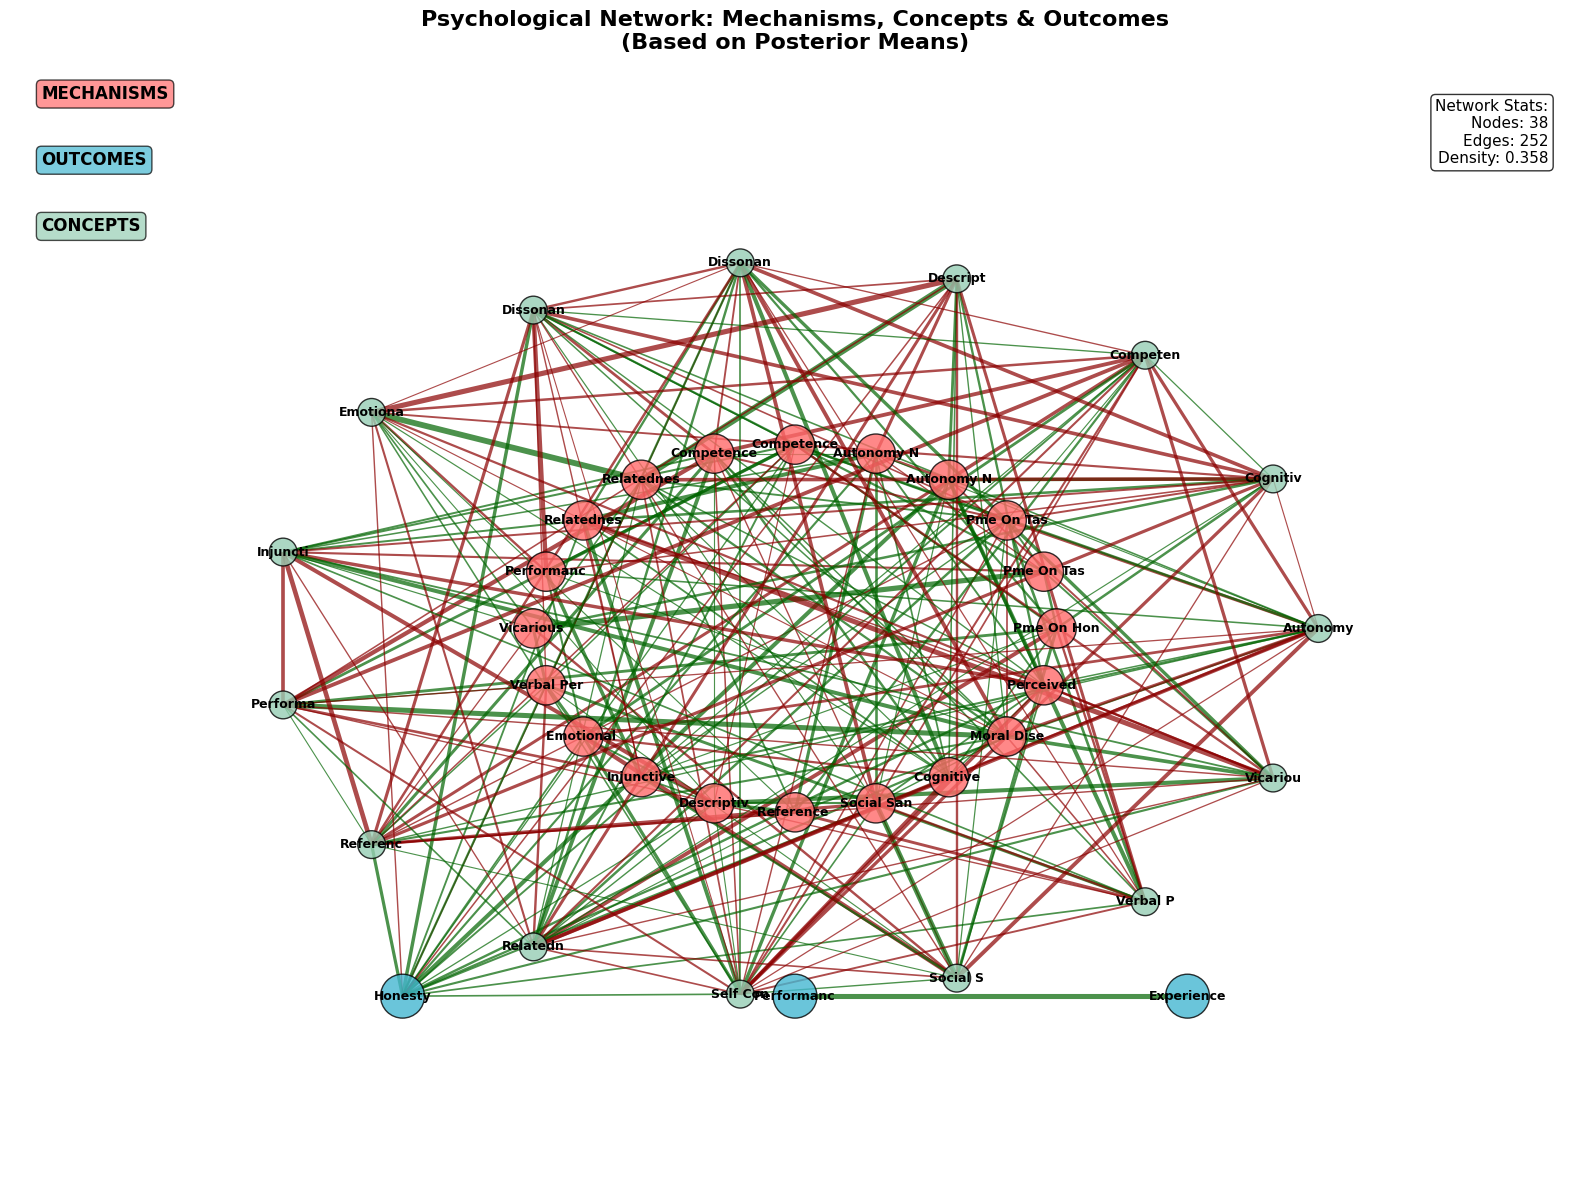

In [54]:
# =============================================================================
# 4. NETWORK VISUALIZATION
# =============================================================================

def create_comprehensive_network(posterior_data, partial_corr_df, threshold=0.1):
    """Create comprehensive network visualization"""
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    labels = list(posterior_data.keys())
    partial_corr = partial_corr_df.values
    
    # Define variable groups
    mechanisms = [var for var in labels if var in available_mechanisms]
    outcomes = ['non_cheating_prob', 'performance', 'experience']
    concepts = [var for var in labels if var.startswith('concept_')]
    
    # Create network graph
    G = nx.Graph()
    for i, label in enumerate(labels):
        G.add_node(i, label=label)
    
    # Add significant edges
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            if abs(partial_corr[i, j]) > threshold:
                G.add_edge(i, j, weight=partial_corr[i, j])
    
    # Create layout
    pos = {}
    
    # Mechanisms in center (circle)
    if mechanisms:
        mech_angles = np.linspace(0, 2*np.pi, len(mechanisms), endpoint=False)
        for i, mech in enumerate(mechanisms):
            if mech in labels:
                idx = labels.index(mech)
                pos[idx] = (0.5 + 0.2 * np.cos(mech_angles[i]), 
                           0.5 + 0.2 * np.sin(mech_angles[i]))
    
    # Outcomes at bottom
    if outcomes:
        out_positions = np.linspace(0.2, 0.8, len(outcomes))
        for i, out in enumerate(outcomes):
            if out in labels:
                idx = labels.index(out)
                pos[idx] = (out_positions[i], 0.1)
    
    # Concepts around the perimeter
    if concepts:
        concept_angles = np.linspace(0, 2*np.pi, len(concepts), endpoint=False)
        for i, concept in enumerate(concepts):
            if concept in labels:
                idx = labels.index(concept)
                pos[idx] = (0.5 + 0.4 * np.cos(concept_angles[i]), 
                           0.5 + 0.4 * np.sin(concept_angles[i]))
    
    # Node colors and sizes
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        label = labels[node]
        if label in mechanisms:
            node_colors.append('#FF6B6B')  # Red for mechanisms
            node_sizes.append(800)
        elif label in outcomes:
            node_colors.append('#45B7D1')  # Blue for outcomes
            node_sizes.append(1000)
        elif label in concepts:
            node_colors.append('#96CEB4')  # Green for concepts
            node_sizes.append(400)
        else:
            node_colors.append('#D3D3D3')  # Gray
            node_sizes.append(300)
    
    # Draw edges
    if G.edges():
        edge_weights = [abs(G[u][v]['weight']) * 8 for u, v in G.edges()]
        edge_colors = ['darkred' if G[u][v]['weight'] < 0 else 'darkgreen' for u, v in G.edges()]
        
        nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, 
                             edge_color=edge_colors, alpha=0.7)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, 
                         node_size=node_sizes, alpha=0.8, edgecolors='black')
    
    # Draw labels
    label_dict = {}
    for node in G.nodes():
        label = labels[node]
        if label.startswith('concept_'):
            label_dict[node] = label.replace('concept_', '').replace('_', ' ').title()[:8]
        elif label == 'non_cheating_prob':
            label_dict[node] = 'Honesty'
        else:
            label_dict[node] = label.replace('_', ' ').title()[:10]
    
    nx.draw_networkx_labels(G, pos, labels=label_dict, ax=ax, 
                          font_size=9, font_weight='bold')
    
    # Add legend
    ax.text(0.02, 0.98, 'MECHANISMS', fontsize=12, fontweight='bold', 
           bbox=dict(boxstyle='round', facecolor='#FF6B6B', alpha=0.7), 
           transform=ax.transAxes)
    ax.text(0.02, 0.92, 'OUTCOMES', fontsize=12, fontweight='bold', 
           bbox=dict(boxstyle='round', facecolor='#45B7D1', alpha=0.7), 
           transform=ax.transAxes)
    ax.text(0.02, 0.86, 'CONCEPTS', fontsize=12, fontweight='bold', 
           bbox=dict(boxstyle='round', facecolor='#96CEB4', alpha=0.7), 
           transform=ax.transAxes)
    
    # Network statistics
    density = len(G.edges()) / (len(labels) * (len(labels) - 1) / 2) if len(labels) > 1 else 0
    
    stats_text = f"""Network Stats:
Nodes: {len(G.nodes())}
Edges: {len(G.edges())}
Density: {density:.3f}"""
    
    ax.text(0.98, 0.98, stats_text, fontsize=11, 
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
           transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.axis('off')
    
    plt.title('Psychological Network: Mechanisms, Concepts & Outcomes\n(Based on Posterior Means)', 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()

create_comprehensive_network(posterior_data, partial_corr_df, threshold=0.1)


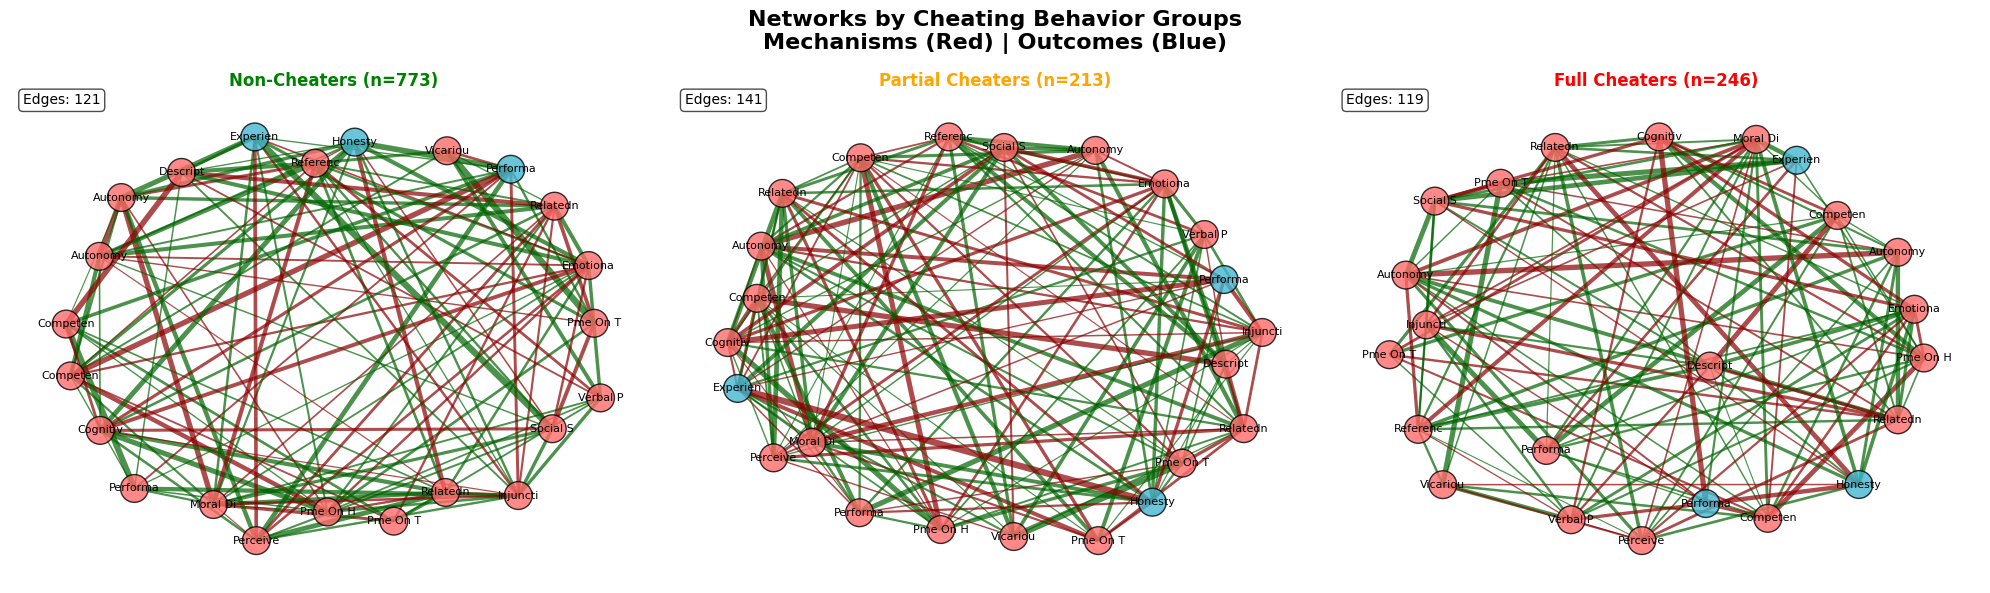

In [55]:
# =============================================================================
# 5. NETWORK BY CHEATING GROUPS
# =============================================================================

def create_networks_by_group(df, posterior_data, threshold=0.1):
    """Create separate networks for each cheating behavior group"""
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    cheating_groups = [0, 1, 2]
    group_names = ['Non-Cheaters', 'Partial Cheaters', 'Full Cheaters']
    group_colors = ['green', 'orange', 'red']
    
    for idx, (group, name, color) in enumerate(zip(cheating_groups, group_names, group_colors)):
        ax = axes[idx]
        
        # Filter for this group
        group_mask = df['cheating_behavior'] == group
        
        if group_mask.sum() < 10:
            ax.text(0.5, 0.5, f'{name}\nn={group_mask.sum()}\nToo few observations', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(name, color=color, fontweight='bold')
            ax.axis('off')
            continue
        
        # Create group data (exclude concepts for group analysis)
        group_data = pd.DataFrame({
            var: values[group_mask] for var, values in posterior_data.items()
            if not var.startswith('concept_')
        })
        
        # Standardize
        scaler = StandardScaler()
        group_data_scaled = pd.DataFrame(
            scaler.fit_transform(group_data),
            columns=group_data.columns
        )
        
        # Partial correlations
        try:
            model = GraphicalLassoCV(cv=3, max_iter=500, alphas=10)
            model.fit(group_data_scaled)
            precision = model.precision_
            diag_sqrt = np.sqrt(np.diag(precision))
            partial_corr = -precision / np.outer(diag_sqrt, diag_sqrt)
            np.fill_diagonal(partial_corr, 0)
        except:
            partial_corr = group_data_scaled.corr().values
            np.fill_diagonal(partial_corr, 0)
        
        # Create network
        G = nx.Graph()
        labels = list(group_data.columns)
        
        for i, label in enumerate(labels):
            G.add_node(i, label=label)
        
        for i in range(len(labels)):
            for j in range(i+1, len(labels)):
                if abs(partial_corr[i, j]) > threshold:
                    G.add_edge(i, j, weight=partial_corr[i, j])
        
        # Layout
        pos = nx.spring_layout(G, k=2, iterations=50)
        
        # Node colors
        node_colors = []
        for node in G.nodes():
            label = labels[node]
            if label in available_mechanisms:
                node_colors.append('#FF6B6B')
            elif label in ['non_cheating_prob', 'performance', 'experience']:
                node_colors.append('#45B7D1')
            else:
                node_colors.append('#D3D3D3')
        
        # Draw network
        if G.edges():
            edge_weights = [abs(G[u][v]['weight']) * 8 for u, v in G.edges()]
            edge_colors = ['darkred' if G[u][v]['weight'] < 0 else 'darkgreen' for u, v in G.edges()]
            
            nx.draw_networkx_edges(G, pos, ax=ax, width=edge_weights, 
                                 edge_color=edge_colors, alpha=0.7)
        
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, 
                             node_size=400, alpha=0.8, edgecolors='black')
        
        # Labels
        label_dict = {i: label.replace('_', ' ').title()[:8] for i, label in enumerate(labels)}
        if 'non_cheating_prob' in labels:
            idx = labels.index('non_cheating_prob')
            label_dict[idx] = 'Honesty'
        
        nx.draw_networkx_labels(G, pos, labels=label_dict, ax=ax, font_size=8)
        
        ax.set_title(f'{name} (n={group_mask.sum()})', color=color, fontweight='bold')
        ax.text(0.02, 0.98, f'Edges: {len(G.edges())}', transform=ax.transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        ax.axis('off')
    
    plt.suptitle('Networks by Cheating Behavior Groups\nMechanisms (Red) | Outcomes (Blue)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

create_networks_by_group(df, posterior_data, threshold=0.1)

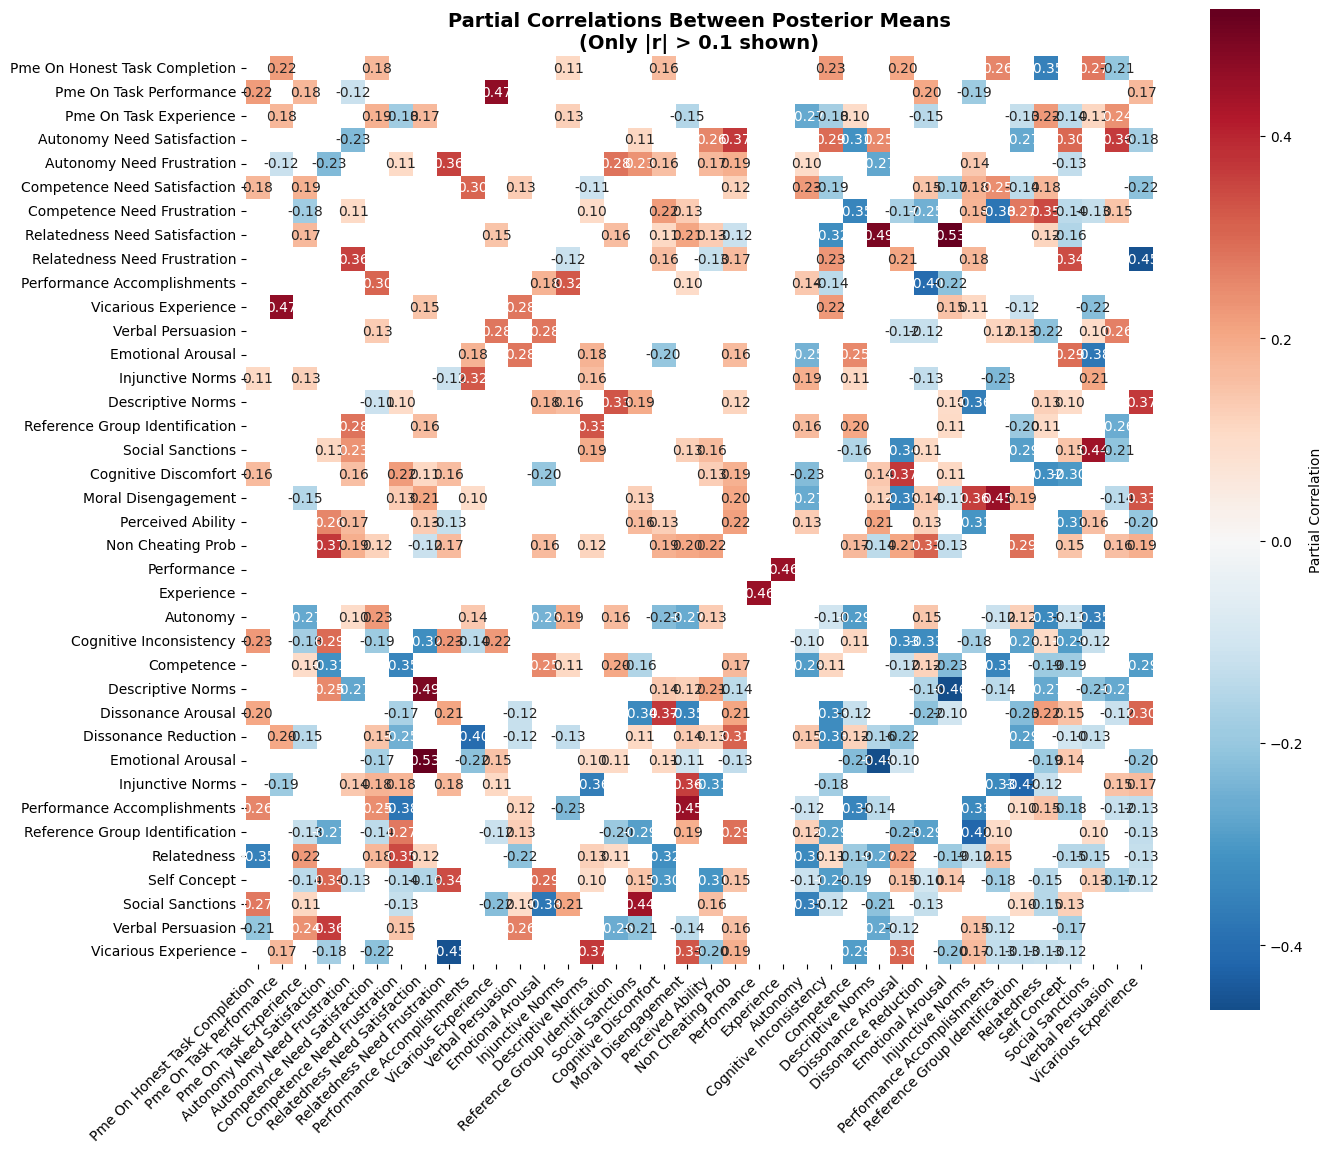


RQ4: Mechanisms model and network analysis completed!


In [56]:
# =============================================================================
# 6. CORRELATION HEATMAP
# =============================================================================

def plot_correlation_heatmap(partial_corr_df, threshold=0.1):
    """Plot heatmap of partial correlations"""
    
    plt.figure(figsize=(14, 12))
    
    # Mask weak correlations
    mask = np.abs(partial_corr_df.values) < threshold
    
    sns.heatmap(partial_corr_df, 
                annot=True, 
                cmap='RdBu_r', 
                center=0, 
                square=True,
                mask=mask,
                fmt='.2f',
                cbar_kws={'label': 'Partial Correlation'},
                xticklabels=[col.replace('_', ' ').replace('concept ', '').title() for col in partial_corr_df.columns],
                yticklabels=[col.replace('_', ' ').replace('concept ', '').title() for col in partial_corr_df.columns])
    
    plt.title(f'Partial Correlations Between Posterior Means\n(Only |r| > {threshold} shown)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(partial_corr_df, threshold=0.1)

print("\nRQ4: Mechanisms model and network analysis completed!")
print("="*70)